In [1]:
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, utils
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

In [24]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 100

'''
Uncomment for MNIST

train_data = datasets.MNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST('./data', train=False,
                           transform=transforms.ToTensor())
'''

'''
Uncomment for FashionMNIST
'''

train_data = datasets.FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False,
                           transform=transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE, shuffle=True)



cuda


In [29]:
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.input_dim = 784
        self.latent_dim = 2
        self.latent_batch_size = 4
        self.input_batch_size = 1#BATCH_SIZE
        
        self.x_sigma = 1.5
        
        self.enc_conv1 = nn.Conv2d(1, 20, 15)
        self.enc_conv2 = nn.Conv2d(20, 40, 8)
        self.enc_conv3_mu = nn.Linear(7*7*40, self.latent_dim)
        self.enc_conv3_logvar = nn.Linear(7*7*40, self.latent_dim)
        
        self.dec_deconv1 = nn.Linear(self.latent_dim, 7*7*40)
        self.dec_deconv2 = nn.ConvTranspose2d(40, 20, 8)
        self.dec_deconv3 = nn.ConvTranspose2d(20, 1, 15)
        
        self.sigm = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0)
    def decoder(self, z):
        dec_out1 = self.dropout(F.relu(self.dec_deconv1(z)))
        dec_out1 = dec_out1.view(dec_out1.shape[0], 40, 7, 7)
        dec_out2 = self.dropout(F.relu(self.dec_deconv2(dec_out1)))
        dec_out = self.sigm(self.dec_deconv3(dec_out2))
        return dec_out
        
    def encoder(self, x):
        enc_out1 = self.dropout(F.relu(self.enc_conv1(x)))
        enc_out2 = self.dropout(F.relu(self.enc_conv2(enc_out1)))
        enc_out2 = enc_out2.view(enc_out2.shape[0], -1)
        enc_out_mu = self.enc_conv3_mu(enc_out2)
        enc_out_logvar = self.enc_conv3_logvar(enc_out2)
        return enc_out_mu, enc_out_logvar
    
    def reparam_trick(self, mu_z, logvar_z):
        sigma_z = torch.exp(logvar_z)
        eps = torch.rand_like(sigma_z)
        return mu_z + eps*sigma_z
    
    def forward(self, x):
        #x = x.view(x.shape[0], -1)
        mu_x, logvar_x = self.encoder(x)
        z_batch = self.reparam_trick(mu_x, logvar_x)
        recon_x_batch = self.decoder(z_batch)
        return recon_x_batch, mu_x, logvar_x

    def loss_function(self, x, recon_x_batch, mu_x, logvar_x):
        x = x.view(x.shape[0], -1)
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
        kl_div = 0.5*torch.sum(mu_x.pow(2) + logvar_x.exp() - logvar_x - 1)/self.input_batch_size
        return recon_loss + kl_div
    


In [30]:
#Skip this block if you want to see the output alone using already trained weights

vae = ConvVAE().to(device)
#optimizer = optim.SGD(vae.parameters(), lr=0.005, weight_decay=1e-5)
optimizer = optim.Adam(vae.parameters())

vae.train()

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        recon_x, mu_x, logvar_x = vae(inputs)
        loss = vae.loss_function(inputs, recon_x, mu_x, logvar_x)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 3480.226
[1,   400] loss: 2829.258
[1,   600] loss: 2764.022
[2,   200] loss: 2724.891
[2,   400] loss: 2701.357
[2,   600] loss: 2688.822
[3,   200] loss: 2678.499
[3,   400] loss: 2663.058
[3,   600] loss: 2655.542
[4,   200] loss: 2648.068
[4,   400] loss: 2643.772
[4,   600] loss: 2646.616
[5,   200] loss: 2641.563
[5,   400] loss: 2629.561
[5,   600] loss: 2624.890
[6,   200] loss: 2628.475
[6,   400] loss: 2620.724
[6,   600] loss: 2618.169
[7,   200] loss: 2627.264
[7,   400] loss: 2612.510
[7,   600] loss: 2611.451
[8,   200] loss: 2608.420
[8,   400] loss: 2611.287
[8,   600] loss: 2606.395
[9,   200] loss: 2597.381
[9,   400] loss: 2599.134
[9,   600] loss: 2614.937
[10,   200] loss: 2607.967
[10,   400] loss: 2594.044
[10,   600] loss: 2592.620
[11,   200] loss: 2587.330
[11,   400] loss: 2590.862
[11,   600] loss: 2606.171
[12,   200] loss: 2594.190
[12,   400] loss: 2587.762
[12,   600] loss: 2589.126
[13,   200] loss: 2592.674
[13,   400] loss: 2578.253
[

In [34]:
#Uncomment for MNIST weights
#PATH = './mnist_net_avg10_2.pth' 

#Uncomment for Fashion MNIST weights
PATH = './fmnist_net_full_large.pth'

#Uncomment to save after training
#torch.save(vae.state_dict(), PATH)

vae_n = ConvVAE()
vae_n.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

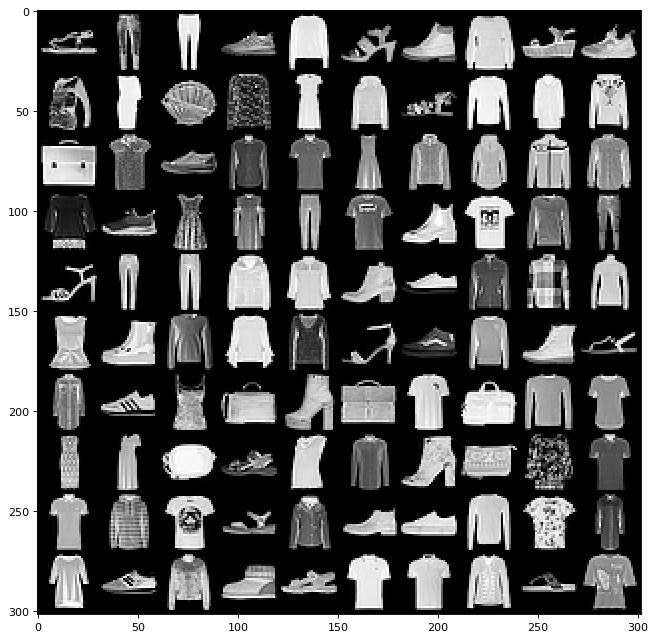

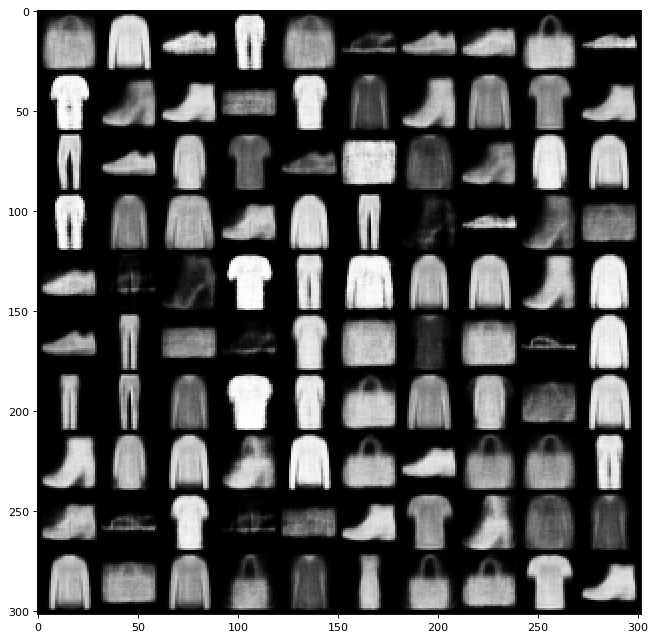

In [35]:
z = torch.randn((100,vae_n.latent_dim))

from matplotlib.pyplot import figure

#Print 100 samples from the dataset
figure(figsize=(10, 10), dpi=80)
image_data, labels = next(iter(train_loader))
image_data = image_data[:,None,:]
image_data = torch.reshape(image_data,(100,1,28,28))
grid_image_data = utils.make_grid(image_data, nrow=10)
grid_image_data_np = grid_image_data.cpu().detach().numpy().transpose(1,2,0)
plt.imshow(grid_image_data_np)
#plt.savefig('mnist_data')
plt.show()

#Print 100 samples using the VAE
figure(figsize=(10, 10), dpi=80)
image_vae = vae_n.decoder(z)
image_vae = image_vae[:, None, :]
image_vae = torch.reshape(image_vae,(100,1,28,28))
grid_image_vae = utils.make_grid(image_vae, nrow=10)
grid_image_vae_np = grid_image_vae.cpu().detach().numpy().transpose(1,2,0)
plt.imshow(grid_image_vae_np)
#plt.savefig('mnist_vae')
plt.show()
